# Piping a Prompt, Model, and an Output Parser

### Before diving into the LCEL syntax, I think it is beneficial to refresh our memory on LangChain concepts such as LLM and Prompt or even a Chain.

* LLM: In langchain, llm is an abstraction around the model used to make the completions such as openai gpt3.5, claude, etc…

* Prompt: This is the input of the LLM object, which will ask the LLM questions and give its objectives.

* Chain: This refers to a sequence of calls to an LLM, or any data processing step.

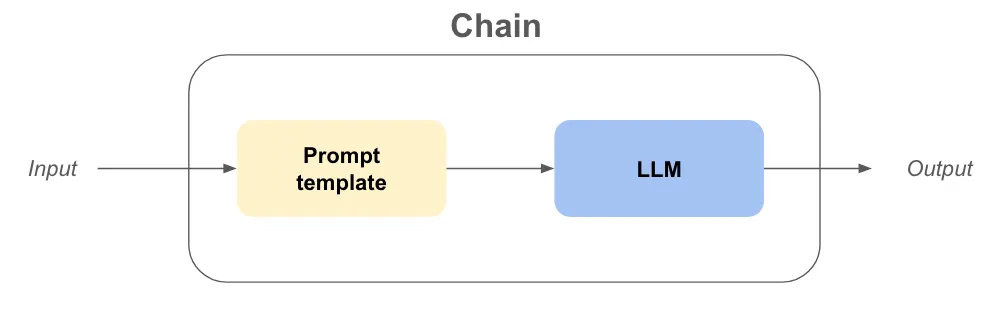

### LangChain Expression Language (LCEL)
* LangChain Expression Language, or LCEL, is a declarative way to easily compose chains together. LCEL was designed from day 1 to support putting prototypes in production, with no code changes, from the simplest “prompt + LLM” chain to the most complex chains (we’ve seen folks successfully run LCEL chains with 100s of steps in production). To highlight a few of the reasons you might want to use LCEL:

##### By using LCEL your chain automatically has:

* .invoke(): You want to pass your input and get the output, nothing more, nothing less.
* .batch(): You want to pass multiple inputs to obtain multiple outputs, the parallelization is handled for you (faster than calling invoke 3 times).
* .stream(): This allows you to start printing the beginning of the completion before the full completion is finished.

In [ ]:
pip show langchain

In [1]:
%load_ext dotenv
%dotenv

In [2]:
from langchain_openai import ChatOpenAI

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser

In [3]:
list_instructions = CommaSeparatedListOutputParser().get_format_instructions()

In [4]:
list_instructions

'Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`'

In [5]:
chat_template = ChatPromptTemplate.from_messages([
    ('human', 
     "I've recently adopted a {pet}. Could you suggest three {pet} names? \n" + list_instructions)])

In [6]:
print(chat_template.messages[0].prompt.template)

I've recently adopted a {pet}. Could you suggest three {pet} names? 
Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`


In [7]:
chat = ChatOpenAI(model_name = 'gpt-4', 
                  model_kwargs = {'seed':365},
                  temperature = 0,
                  max_tokens = 100)

C:\Users\HP\anaconda3\envs\longchain_env\lib\site-packages\IPython\core\interactiveshell.py:3519: UserWarning: Parameters {'seed'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if await self.run_code(code, result, async_=asy):


In [8]:
list_output_parser = CommaSeparatedListOutputParser()

In [9]:
chat_template_result = chat_template.invoke({'pet':'dog'})

In [10]:
chat_result = chat.invoke(chat_template_result)

In [11]:
list_output_parser.invoke(chat_result)

['Max', 'Bella', 'Charlie']

In [12]:
chain = chat_template | chat | list_output_parser

In [13]:
chain.invoke({'pet':'dog'})

['Max', 'Bella', 'Cooper']

# Batching

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [2]:
chat_template = ChatPromptTemplate.from_messages([
    ('human', 
     "I've recently adopted a {pet} which is a {breed}. Could you suggest several training tips?")])

In [3]:
chat = ChatOpenAI(model_name = 'gpt-4', 
                  model_kwargs = {'seed':365},
                  temperature = 0,
                  max_tokens = 100)

C:\Users\HP\anaconda3\envs\longchain_env\lib\site-packages\IPython\core\interactiveshell.py:3519: UserWarning: Parameters {'seed'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if await self.run_code(code, result, async_=asy):


In [4]:
chain = chat_template | chat

In [5]:
chain.invoke({'pet':'dog', 'breed':'shepherd'})

AIMessage(content="1. Start Training Early: Begin training your shepherd dog as soon as you bring him home. This breed is intelligent and eager to learn, so starting early will help establish good behavior.\n\n2. Consistency is Key: Be consistent with your commands and expectations. If you allow your dog to do something once, he will think it's always acceptable. \n\n3. Positive Reinforcement: Always use positive reinforcement when training. This could be in the form of treats, praise, or petting. Never", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 25, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-4aa439f2-ebf8-48ba-9776-bdb8304a3

In [6]:
%%time
chain.batch([{'pet':'dog', 'breed':'shepherd'}, 
             {'pet':'dragon', 'breed':'night fury'}])

CPU times: total: 15.6 ms
Wall time: 3.93 s


[AIMessage(content="1. Start Training Early: Begin training your shepherd dog as soon as you bring them home. This will help them understand their boundaries and what is expected of them.\n\n2. Consistency is Key: Be consistent with your commands and training. If you allow your dog to do something once, they will think it's always acceptable. \n\n3. Use Positive Reinforcement: Always reward good behavior with treats, praise, or playtime. This will encourage your dog to repeat the behavior.\n\n4. Social", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 25, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-c1a207af-cffc-4d9d-bc03-6bf312680f

* <b> CPU time </b> refers to the actual time the processor spent executing your code (sum of all cores if multithreaded).
* <b> Wall time </b> (also called real time) is the total time elapsed from the start to the end of execution, including CPU processing, I/O operations, waiting for other processes, and system overhead.

In [7]:
%%time
# individual pass 1
chain.invoke({'pet':'dog', 'breed':'shepherd'})

CPU times: total: 0 ns
Wall time: 2.95 s


AIMessage(content="1. Start Training Early: Begin training your shepherd dog as soon as you bring him home. This breed is intelligent and eager to learn, so starting early will help establish good behavior.\n\n2. Consistency is Key: Be consistent with your commands and expectations. If you allow your dog to do something once, he will think it's always acceptable. \n\n3. Use Positive Reinforcement: Always reward good behavior with treats, praise, or playtime. This will encourage your dog to repeat the behavior", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 25, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-bc8d2f4e-267b-4c2d-be1a-24d

In [8]:
%%time
# individual pass 2
chain.invoke({'pet':'dragon', 'breed':'night fury'})

CPU times: total: 15.6 ms
Wall time: 3.96 s


AIMessage(content='Training a dragon, especially a Night Fury, is no small task. Here are some tips to help you:\n\n1. Establish Trust: Night Furies are intelligent and sensitive creatures. They need to trust you before they can be trained. Spend time with your dragon, talk to it, and show it that you mean no harm.\n\n2. Understand Their Behavior: Night Furies are nocturnal creatures. They are most active during the night and prefer to hunt in the dark. Understanding their behavior will help', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 26, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-e86ac57d-c2ec-4f9c-9b48-a1026478b29e-0', usag